In [1]:
import cv2
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('../data/test/')
subset = 'a'
json_ref_file = data_dir / 'b_annotations.json'
json_pred_file = Path('../submit/out.json')

In [3]:
with open(str(json_pred_file), 'r') as f:
    preds = json.load(f)

imgs = preds['images']
annotations = preds['annotations']

with open(str(json_ref_file), 'r') as f:
    refs = json.load(f)
    
categories = refs['categories']
imgs_ref = refs['images']
annotations_ref = refs['annotations']

In [4]:
num_classes = len(categories)
classes = []
class_ids = []
for category in categories:
    classes.append(category['name'])
    class_ids.append(category['id'])

class_ids = np.array(class_ids)
classes = np.array(classes)

In [5]:
def get_image_annotation(index):
    img_info = imgs[index]
    img_name = img_info['file_name']
    img_path = data_dir / '{}_images'.format(subset) / img_name
    img_id = img_info['id']
    bbox_list = []
    cls_list = []
    for gt in annotations:
        if gt['image_id'] == img_id:
            bbox = gt['bbox']
            cls_id = gt['category_id']
            bbox_list.append(bbox)
            cls_list.append(cls_id)
    return {'img_path': img_path, 'bbox_list': bbox_list, 'cls_list': cls_list}

In [6]:
def get_product_annotation(index):
    img_path = ''
    for img_info in imgs_ref:
        img_id = img_info['id']
        if img_id == index:
            img_name = img_info['file_name']
            img_path = data_dir / 'b_images' / img_name
            break
    
    if img_path == '':
        print('Product image with index {} not found'.format(index))
        return
    
    bbox_list = []
    cls_list = []
    for gt in annotations_ref:
        if gt['image_id'] == index:
            bbox = gt['bbox']
            cls_id = gt['category_id']
            bbox_list.append(bbox)
            cls_list.append(cls_id)
    return {'img_path': img_path, 'bbox_list': bbox_list, 'cls_list': cls_list}

In [7]:
colors = np.random.randint(0, 255, size=(classes.shape[0], 3), dtype=np.uint8)
plt.rcParams['figure.figsize'] = [15, 15]

def show_example(example_index):
    gt_dict = get_image_annotation(example_index)
    img_path = gt_dict['img_path']
    bbox_list = gt_dict['bbox_list']
    cls_list = gt_dict['cls_list']
    img = cv2.imread(str(img_path))
    cls_ids_example = []
    for i, bbox in enumerate(bbox_list):
        cls_id = cls_list[i]
        cls_ids_example.append(cls_id)
        cls_name = classes[cls_id]
        x1, y1, w, h = bbox
        color = colors[cls_id].tolist()
        cv2.rectangle(img, (x1, y1), (x1+w, y1+h), color, 3)
        cv2.putText(img, cls_name, (x1+10, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    return cls_ids_example

In [8]:
def find_products_with_class(cls_ids_example):
    product_ids = {}
    for ann in annotations_ref:
        cls_id = ann['category_id']
        img_id = ann['image_id']
        if cls_id in cls_ids_example and cls_id not in product_ids:
            product_ids[cls_id] = img_id
    return product_ids

In [9]:
def show_products(product_ids):
    for cls_id in product_ids:
        img_id = product_ids[cls_id]
        gt_dict = get_product_annotation(img_id)
        img_path = gt_dict['img_path']
        bbox_list = gt_dict['bbox_list']
        cls_list = gt_dict['cls_list']
        img = cv2.imread(str(img_path))
        for i, bbox in enumerate(bbox_list):
            cls_id = cls_list[i]
            cls_name = classes[cls_id]
            x1, y1, w, h = bbox
            color = colors[cls_id].tolist()
            cv2.rectangle(img, (x1, y1), (x1+w, y1+h), color, 3)
            cv2.putText(img, cls_name, (x1+10, y1 + 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

In [78]:
# 漏检 374 1022 1026 193 1271 745 982 1308 452 574 84
# 重检 1151 745 314 489 1450 352 903 841 305 311 1038 1224 321 1044 574 84
# 分类错误 854 781 1026 932 745 1307 1096 189 1159 352 968 272 509 305 574 84(dongpeng & hongniu, kafei & AD, rousongbin & haoliyou, xiangguolao & youlemei, kele & wanglaoji)
# 误检 1021 521 958
# 定位不准 253 450 
# 对瓶子检测较好，盒子检测有漏检或重检

1245


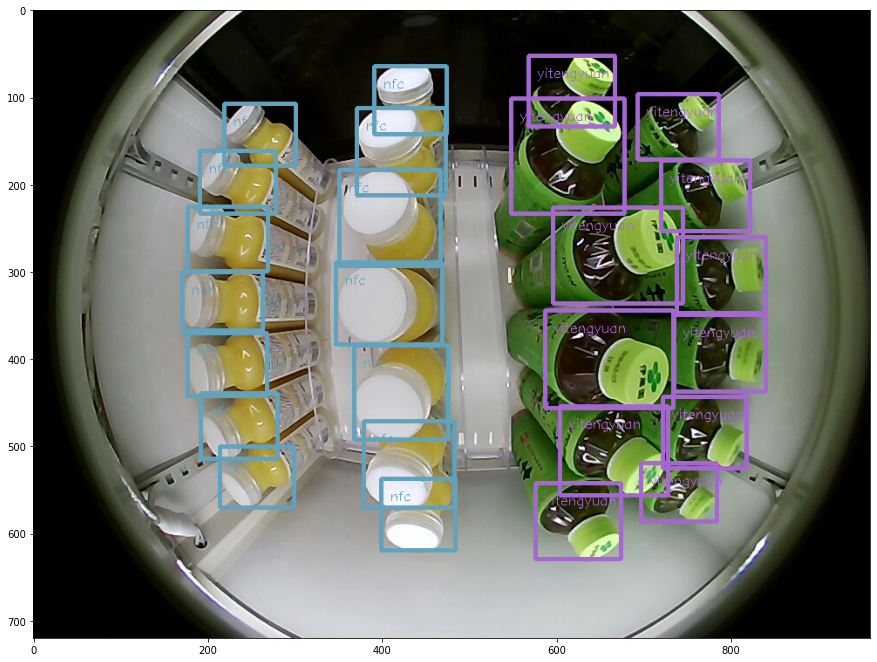

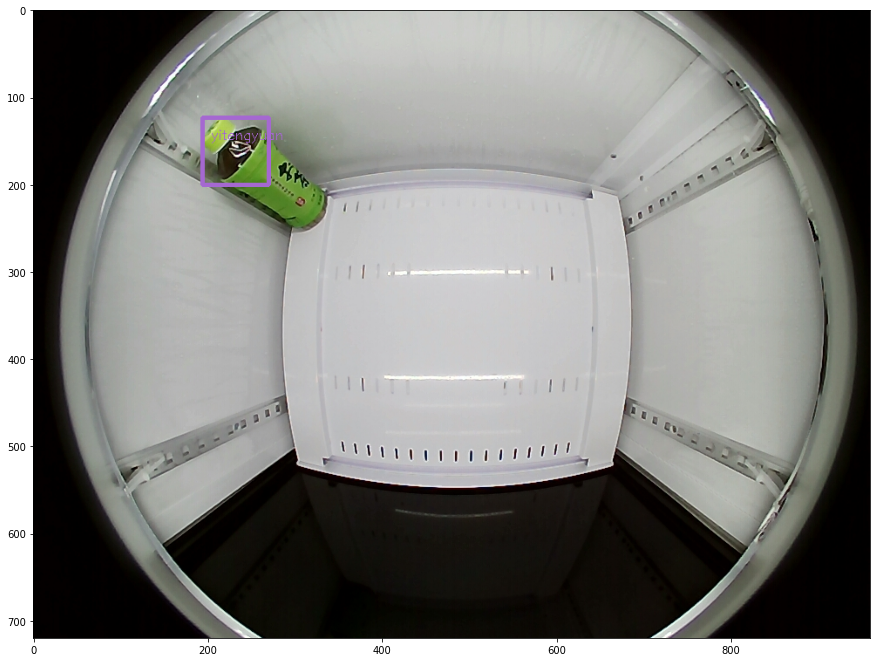

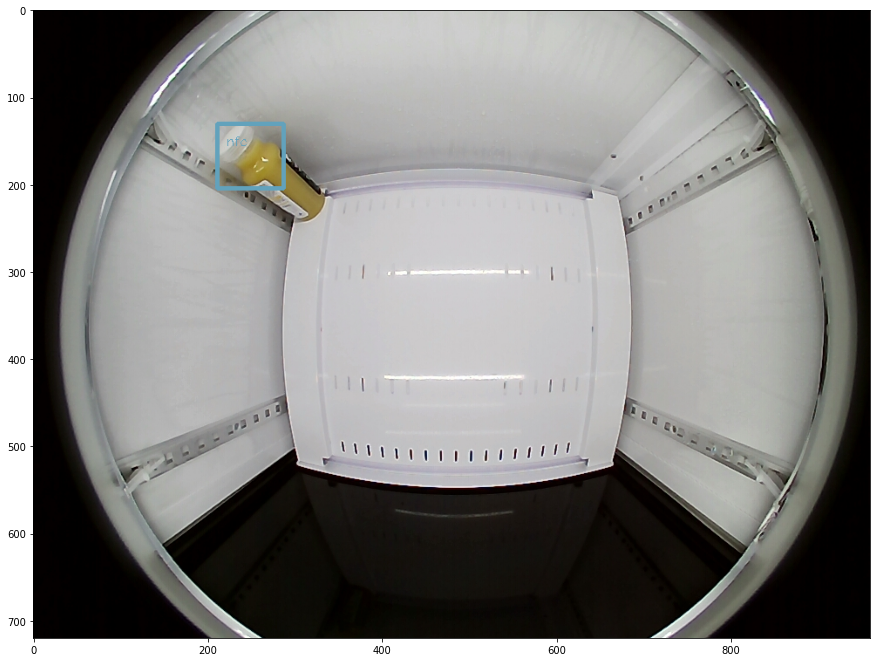

In [199]:
idx = np.random.randint(len(imgs))
print(idx)
# 352
cls_ids_example = show_example(idx)
product_ids = find_products_with_class(cls_ids_example)
show_products(product_ids)